#Ambrose Desmond MSC_DA_CA2

## Irelands Dairy sector analysis compared to the top EU producer and global producers.

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import statistics as stats
from scipy.stats import poisson
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
from sklearn.feature_selection import RFE
import json
import requests
import time
# from faker import Factory,Faker
warnings.filterwarnings('ignore') # supress warnings

In [51]:
# Import the dairy csv as ddf
ddf = pd.read_csv("Intake of Cows Milk by Creameries and Pasteurisers.csv")

In [52]:
ddf.shape

(575, 4)

In [53]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          575 non-null    object 
 1   Intake of Cows Milk by Creameries and Pasteurisers  574 non-null    object 
 2   Fat Content                                         514 non-null    float64
 3   Protein Content                                     514 non-null    float64
dtypes: float64(2), object(2)
memory usage: 18.1+ KB


In [54]:
ddf.head()

,Unnamed: 0,Intake of Cows Milk by Creameries and Pasteurisers,Fat Content,Protein Content
0,"Source: Central Statistics Office, Ireland.",NaN,NaN,NaN
1,1975 January,55.8,NaN,NaN
2,1975 February,84.4,NaN,NaN
3,1975 March,193.3,NaN,NaN
4,1975 April,327.5,NaN,NaN


In [56]:
# need to drop the first row as its not part of the actual data.
ddf.drop(index=ddf.index[0], axis=0, inplace=True)
# alternativaly i could have used ddf.iloc[1:] to select everything except the first row and 
# and store it in a new dataframe. here I chose to use the drop() function with index 0 ( ie first line) the axis 0 indicates row
# and inplace = true performs the operation to the existing  dataframe. I chose this because It saves space to 
# edit the existing dataframe instead of creating new ones which the other methods do.

In [57]:
# formatt the data to give concise and meaningfull headings to the dataframe,
# I did this because it will make reading the dataframe easier for myself and other people looking at it

ddf.columns = ['date','milk','fat','pro']
ddf.head()

,date,milk,fat,pro
1,1975 January,55.8,NaN,NaN
2,1975 February,84.4,NaN,NaN
3,1975 March,193.3,NaN,NaN
4,1975 April,327.5,NaN,NaN
5,1975 May,493.5,NaN,NaN


In [63]:
#I want to convert date string  colum to datetime object because datetime objects are easier to manipulate
# espicallyif the date is in the index. there is dedicated functionality with date time objects.
ddf[["date"]] = ddf[["date"]].apply(pd.to_datetime)
# my .info() on the dataframe revealed the milk colum is type object. I want to converted this to float type 
# because this data type is best interpertiped numerically for manipulation in charts and models.
#  My inital attempt of ddf['milk'] = ddf['milk'].astype(float)
# got an error trying to convert str to float ValueError: could not convert string to float: '1,072.2'
# the problem here is the comma seperasting thousands , need to strip these out and try again.
# Im using a lambda function on the milk column to strip the comma .
# I chose to use lambda because its a singl euse function that saves time and space v writing a dedicated function.
ddf['milk'] = ddf['milk'].apply(lambda x : x.replace(',',''))
ddf['milk'] = ddf['milk'].astype(float)

,date,milk,fat,pro
1,1975-01-01,55.8,NaN,NaN
2,1975-02-01,84.4,NaN,NaN
3,1975-03-01,193.3,NaN,NaN
4,1975-04-01,327.5,NaN,NaN
5,1975-05-01,493.5,NaN,NaN


In [64]:
# Selecting the last 10 years of data.This will conviently remove the dates where fat and pro data
# was not being collected.

ddfd = ddf[(ddf['date'] >= '2012-01-01')]
ddfd.tail()

,date,milk,fat,pro
570,2022-06-01,1057.60,4.00,3.47
571,2022-07-01,1022.80,4.03,3.47
572,2022-08-01,919.01,4.21,3.53
573,2022-09-01,785.62,4.56,3.75
574,2022-10-01,698.49,4.81,3.97


In [66]:
# Checking data for any nan values , shows none. I did this because nan values have detrimental effecrts on 
# models 
ddfd.isna().sum() 

date    0
milk    0
fat     0
pro     0
dtype: int64

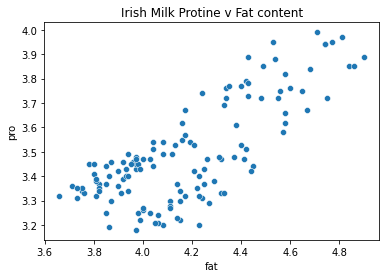

In [76]:
sns.scatterplot(data=ddfd, x= 'fat', y='pro').set(title = 'Irish Milk Protine v Fat content')
plt.show()
# plt.savefig("ff_IN_OUT_scatter1.png", dpi=300)
# There are no outliers jumping out here 

[Text(0.5, 1.0, 'Irish Milk Vol over time')]

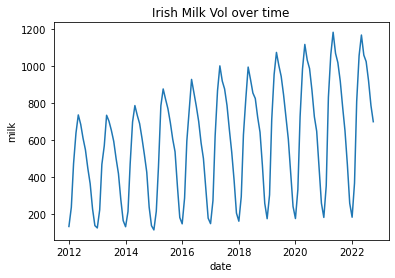

In [83]:
sns.lineplot(data=ddfd, x= 'date', y='milk').set(title = 'Irish Milk Vol over time')

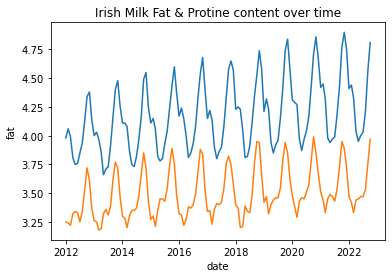

In [84]:
sns.lineplot(data=ddfd, x= 'date', y='fat').set(title = 'Irish Milk Fat & Protine content over time')
sns.lineplot(data=ddfd, x= 'date', y='pro')
plt.show()

In [87]:
# import Irish dairy price  as dpdf
dpdf = pd.read_csv("AJM07.20221211151826.csv")

In [90]:
dpdf.tail()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
421,AJM07,Manufacturing Milk Prices (including VAT),202207,2022 July,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.549
422,AJM07,Manufacturing Milk Prices (including VAT),202208,2022 August,1,"Milk (per litre), actual fat and protein",Euro,0.616
423,AJM07,Manufacturing Milk Prices (including VAT),202208,2022 August,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.557
424,AJM07,Manufacturing Milk Prices (including VAT),202209,2022 September,1,"Milk (per litre), actual fat and protein",Euro,0.662
425,AJM07,Manufacturing Milk Prices (including VAT),202209,2022 September,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.559


In [89]:
dpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        426 non-null    object 
 1   STATISTIC Label  426 non-null    object 
 2   TLIST(M1)        426 non-null    int64  
 3   Month            426 non-null    object 
 4   C02136V02577     426 non-null    int64  
 5   Product          426 non-null    object 
 6   UNIT             426 non-null    object 
 7   VALUE            426 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 26.8+ KB


In [92]:
dpdf[["Month"]] = dpdf[["Month"]].apply(pd.to_datetime)

In [93]:
dpdf.head()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
0,AJM07,Manufacturing Milk Prices (including VAT),200501,2005-01-01,1,"Milk (per litre), actual fat and protein",Euro,0.308
1,AJM07,Manufacturing Milk Prices (including VAT),200501,2005-01-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.301
2,AJM07,Manufacturing Milk Prices (including VAT),200502,2005-02-01,1,"Milk (per litre), actual fat and protein",Euro,0.288
3,AJM07,Manufacturing Milk Prices (including VAT),200502,2005-02-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.281
4,AJM07,Manufacturing Milk Prices (including VAT),200503,2005-03-01,1,"Milk (per litre), actual fat and protein",Euro,0.272


In [97]:
dpdf = dpdf[(dpdf['Month'] >= '2012-01-01')]
dpdf.tail()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
421,AJM07,Manufacturing Milk Prices (including VAT),202207,2022-07-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.549
422,AJM07,Manufacturing Milk Prices (including VAT),202208,2022-08-01,1,"Milk (per litre), actual fat and protein",Euro,0.616
423,AJM07,Manufacturing Milk Prices (including VAT),202208,2022-08-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.557
424,AJM07,Manufacturing Milk Prices (including VAT),202209,2022-09-01,1,"Milk (per litre), actual fat and protein",Euro,0.662
425,AJM07,Manufacturing Milk Prices (including VAT),202209,2022-09-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.559


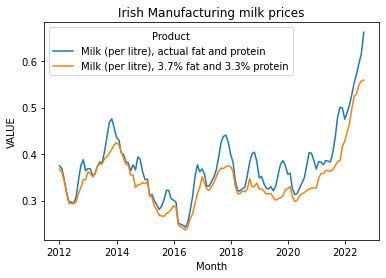

In [98]:
sns.lineplot(data=dpdf, x= 'Month', y='VALUE',hue='Product').set(title = 'Irish Manufacturing Milk Prices')
plt.show()

In [99]:
#!pip install odfpy

     |████████████████████████████████| 717 kB 511 kB/s eta 0:00:01     |███████████▍                    | 256 kB 511 kB/s eta 0:00:01
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=137339 sha256=6b7cdf975cf03b592231a711a0be3abcfb216b7199a35ca499c00315c291d9c0
  Stored in directory: /Users/ambrosedesmond/Library/Caches/pip/wheels/20/ff/69/1b3f423ffe400b87afa368c70b43d2b5cd3bfb9ac8a613ba5b
Successfully built odfpy


In [123]:
eudf = pd.read_csv("apro_mk_cola_page_linear.csv")

In [124]:
eudf.head()

,DATAFLOW,LAST UPDATE,freq,dairyprod,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2017,57.36,p
1,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2018,64.39,NaN
2,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2019,56.82,NaN
3,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2020,56.27,NaN
4,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2021,58.94,NaN


In [125]:
eudf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     396 non-null    object 
 1   LAST UPDATE  396 non-null    object 
 2   freq         396 non-null    object 
 3   dairyprod    396 non-null    object 
 4   unit         396 non-null    object 
 5   geo          396 non-null    object 
 6   TIME_PERIOD  396 non-null    int64  
 7   OBS_VALUE    373 non-null    float64
 8   OBS_FLAG     59 non-null     object 
dtypes: float64(1), int64(1), object(7)
memory usage: 28.0+ KB


In [126]:
uniqueValsList = list(np.unique(np.array(eudf['geo'])))
uniqueValsList

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EFTA',
 'EL',
 'ES',
 'EU15',
 'EU25',
 'EU27_2007',
 'EU27_2020',
 'EU28',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR',
 'UK']

In [127]:
eudf['geo'] = eudf['geo'].apply(lambda x : len(x)<= 2)

In [128]:
uniqueValsList = list(np.unique(np.array(eudf['geo'])))
uniqueValsList

[False, True]

In [117]:
import plotly.express as px
fig = px.choropleth(eudff, locations="geo",
                    color="OBS_VALUE", 
                    hover_name="geo", 
                    # column to add to hover information
                    animation_frame="TIME_PERIOD", 
                    # column on which to animate
                    color_continuous_scale=px.colors.sequential.Plasma)
                    
fig.update_layout(
    # add a title text for the plot
    title_text = 'Milk Production',
    # set projection style for the plot
    geo = dict(projection={'type':'natural earth'}) # by default, projection type is set to 'equirectangular'
)
fig.show()

ValueError: Value of 'animation_frame' is not the name of a column in 'data_frame'. Expected one of ['geo'] but received: TIME_PERIOD